In [ ]:
import requests

# Variabel yang diperlukan
protocol = "https"
ip_or_domain = "platform.antares.id"
port = "8443"
cse_id = "antares-id"
cse_name = "antares-cse"
application_name = "AMIModule"
device_name = "LoRa_Gateway"
access_key = "fbcc54e8fa44769a:601102b2dae28971"

# Membangun URL
url = f"https://platform.antares.id:8443/~/antares-cse/antares-id/{application_name}/{device_name}?lim=50000&fu=1&drt=2&ty=4"
# irl = f"{protocol}://{ip_or_domain}:{port}/~/{cse-id}/{cse-name}/{application-name}/{device-name}?lim=50000&fu=1&drt=2&ty=4"
# Header yang diperlukan
headers = {
    "Accept": "application/json",
    "X-M2M-Origin": access_key,
    "Content-Type": "application/json"
}

# Mengirim GET request
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Memeriksa apakah ada error dalam respons

    # Mengambil data JSON dari respons
    data = response.json()
    print("Raw JSON yang diterima")
    print(data)

except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
except requests.exceptions.RequestException as err:
    print(f"Error occurred: {err}")


In [99]:
import pandas as pd
import json
from datetime import datetime

def convert_to_dataframe(json_data):
    if not json_data or "m2m:list" not in json_data:
        print("Invalid JSON structure")
        return pd.DataFrame()
    
    records = []
    for item in json_data["m2m:list"]:
        cin = item.get("m2m:cin", {})
        con_raw = cin.get("con", "{}")

        # Bersihkan karakter kontrol yang mungkin menyebabkan error
        con_raw = con_raw.replace("\n", "").replace("\t", "").replace("\r", "")

        try:
            con_data = json.loads(con_raw, strict=False)  # Gunakan strict=False untuk mengabaikan error karakter kontrol
            ct_raw = cin.get("ct", "")  # Tambah kolom received_at_server
            formatted_ct = datetime.strptime(ct_raw, "%Y%m%dT%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
            con_data["received_at_server"] = formatted_ct # Tambah kolom received_at_server
            
            records.append(con_data)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
            print(f"Problematic data: {con_raw}")

    return pd.DataFrame(records)

df = convert_to_dataframe(data)

In [100]:
df.head()

,devUI,time_at_device,time_received_at_gateway,time_send_from_gateway,RSSI,protocol,voltage,current,power,energy,frequency,power_factor,received_at_server
0,08:D1:F9:35:B5:48,2025-03-11 06:43:21,2025-03-11 06:43:37,2025-03-11 06:43:37.538,-103,http,232.70,0.23,35.80,2.11,433000000.0,0.67,2025-03-11 06:43:38
1,08:D1:F9:35:B5:48,2025-03-11 06:43:11,2025-03-11 06:43:27,2025-03-11 06:43:27.185,-105,http,232.50,0.22,34.20,2.11,433000000.0,0.66,2025-03-11 06:43:28
2,08:D1:F9:35:B5:48,2025-03-11 06:43:01,2025-03-11 06:43:16,2025-03-11 06:43:16.831,-105,mqtt,232.40,0.22,33.20,2.11,433000000.0,0.65,2025-03-11 06:43:16
3,08:D1:F9:35:B5:48,2025-03-11 06:42:50,2025-03-11 06:43:06,2025-03-11 06:43:06.483,-105,mqtt,232.50,0.25,40.10,2.11,433000000.0,0.70,2025-03-11 06:43:06
4,08:D1:F9:35:B5:48,2025-03-11 06:42:40,2025-03-11 06:42:56,2025-03-11 06:42:56.122,-105,mqtt,232.30,0.24,38.20,2.11,433000000.0,0.69,2025-03-11 06:43:01


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   devUI                     2000 non-null   object
 1   time_at_device            2000 non-null   object
 2   time_received_at_gateway  2000 non-null   object
 3   time_send_from_gateway    2000 non-null   object
 4   RSSI                      2000 non-null   int64 
 5   protocol                  2000 non-null   object
 6   voltage                   2000 non-null   object
 7   current                   2000 non-null   object
 8   power                     2000 non-null   object
 9   energy                    2000 non-null   object
 10  frequency                 2000 non-null   object
 11  power_factor              2000 non-null   object
 12  received_at_server        2000 non-null   object
dtypes: int64(1), object(12)
memory usage: 203.3+ KB


In [102]:
numeric_columns = ["voltage", "current", "power", "energy", "frequency", "power_factor"]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [103]:
df.describe()

,RSSI,voltage,current,power,energy,frequency,power_factor
count,2000.000000,1971.000000,1967.000000,1968.000000,1969.000000,1.973000e+03,1968.000000
mean,-108.139000,232.667986,0.285480,43.992475,1.791163,4.321221e+08,0.638755
std,3.738137,1.488755,0.121081,20.926464,0.238233,1.948156e+07,0.083583
min,-130.000000,228.200000,0.100000,8.700000,1.510000,5.000000e+01,0.340000
25%,-111.000000,231.600000,0.230000,35.000000,1.580000,4.330000e+08,0.640000
50%,-110.000000,232.700000,0.250000,39.600000,1.640000,4.330000e+08,0.670000
75%,-105.000000,233.700000,0.410000,63.925000,2.050000,4.330000e+08,0.680000
max,-99.000000,237.000000,0.640000,107.700000,2.110000,4.330000e+08,0.770000


In [104]:
print(df["voltage"].isna().sum())


29


In [105]:
numeric_columns = ["voltage", "current", "power", "energy", "frequency", "power_factor"]
df_nan = df[df[numeric_columns].isna().any(axis=1)]
print("mean of nan balue: ", df_nan["RSSI"].mean())
print("min RSSI of nan value: ",df_nan["RSSI"].max())

mean of nan balue:  -116.51515151515152
min RSSI of nan value:  -103


In [106]:
numeric_columns = ["voltage", "current", "power", "energy", "frequency", "power_factor"]
df_non_nan = df[df[numeric_columns].notna().any(axis=1)]
df_non_nan = df.dropna(subset=numeric_columns)

df_non_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1967 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   devUI                     1967 non-null   object 
 1   time_at_device            1967 non-null   object 
 2   time_received_at_gateway  1967 non-null   object 
 3   time_send_from_gateway    1967 non-null   object 
 4   RSSI                      1967 non-null   int64  
 5   protocol                  1967 non-null   object 
 6   voltage                   1967 non-null   float64
 7   current                   1967 non-null   float64
 8   power                     1967 non-null   float64
 9   energy                    1967 non-null   float64
 10  frequency                 1967 non-null   float64
 11  power_factor              1967 non-null   float64
 12  received_at_server        1967 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 215.1+ KB


In [107]:
print(df_non_nan["RSSI"].mean())

-107.99847483477377


## Save to excel
```python
import openpyxl

def remove_illegal_chars(value):
    """Hapus karakter ilegal dari string"""
    if isinstance(value, str):
        return "".join(c for c in value if c.isprintable())  # Hapus karakter tidak terlihat
    return value
def save_to_excel(df, filename="output.xlsx"):
    df = df.applymap(remove_illegal_chars)
    df.to_excel(filename, index=False)
    print(f"Data saved to {filename}")

save_to_excel(df, "11_maret.xlsx")

```

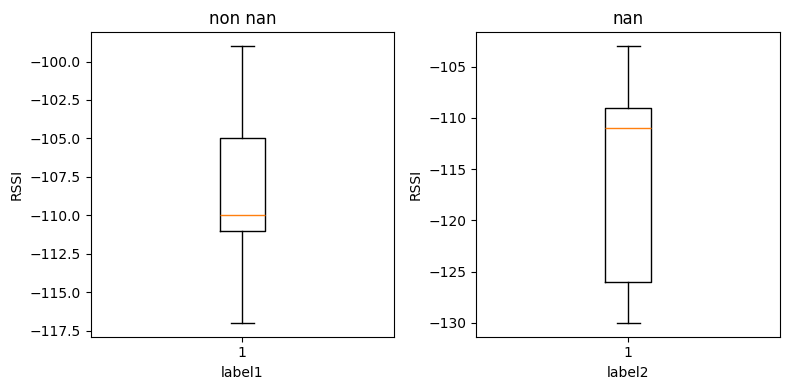

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_two_boxplots(df1, df2, column="RSSI", title1="DataFrame 1", title2="DataFrame 2", label1="label1", label2="label2"):

    # Membuat figure dan axes
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Boxplot untuk kolom "RSSI" di DataFrame pertama
    axes[0].boxplot(df1[column])
    axes[0].set_title(title1)
    axes[0].set_ylabel(column)
    axes[0].set_xlabel(label1)

    # Boxplot untuk kolom "RSSI" di DataFrame kedua
    axes[1].boxplot(df2[column])
    axes[1].set_title(title2)
    axes[1].set_ylabel(column)
    axes[1].set_xlabel(label2)

    # Menampilkan plot
    plt.tight_layout()
    plt.show()

plot_two_boxplots(df_non_nan, df_nan, column="RSSI", title1="non nan", title2="nan")

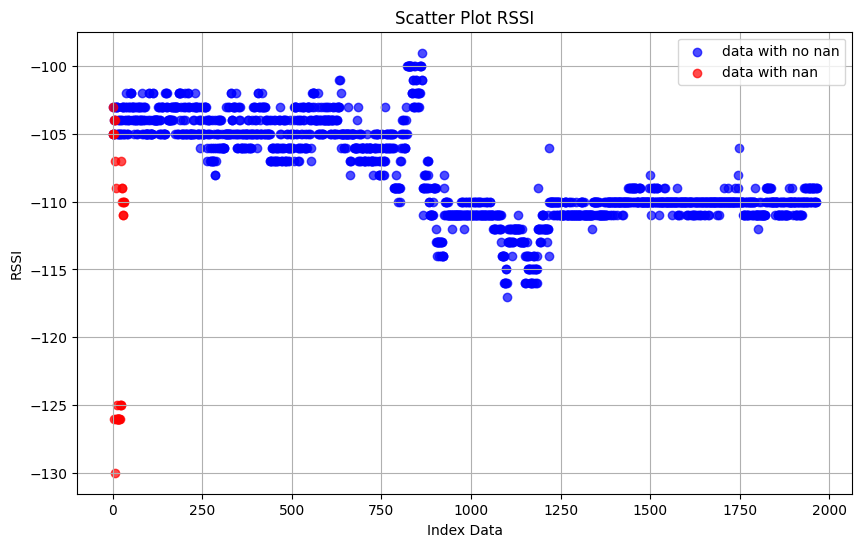

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_two_scatter(df1, df2, column="RSSI", title="Scatter Plot", label1="data 1", label2="data 2"):

    plt.figure(figsize=(10, 6))

    # Scatter plot untuk DataFrame pertama
    plt.scatter(range(len(df1)), df1[column], label=label1, color='blue', alpha=0.7)

    # Scatter plot untuk DataFrame kedua
    plt.scatter(range(len(df2)), df2[column], label=label2, color='red', alpha=0.7)

    # Menambahkan judul dan label
    plt.title(title)
    plt.xlabel('Index Data')
    plt.ylabel(column)
    plt.legend()

    # Menampilkan plot
    plt.grid(True)
    plt.show()

plot_two_scatter(df_non_nan, df_nan, column="RSSI", title="Scatter Plot RSSI", label1="data with no nan", label2="data with nan")

In [110]:
df['time_send_from_gateway'] = df['time_send_from_gateway'].str.split('.').str[0]
df.head()

,devUI,time_at_device,time_received_at_gateway,time_send_from_gateway,RSSI,protocol,voltage,current,power,energy,frequency,power_factor,received_at_server
0,08:D1:F9:35:B5:48,2025-03-11 06:43:21,2025-03-11 06:43:37,2025-03-11 06:43:37,-103,http,232.7,0.23,35.8,2.11,433000000.0,0.67,2025-03-11 06:43:38
1,08:D1:F9:35:B5:48,2025-03-11 06:43:11,2025-03-11 06:43:27,2025-03-11 06:43:27,-105,http,232.5,0.22,34.2,2.11,433000000.0,0.66,2025-03-11 06:43:28
2,08:D1:F9:35:B5:48,2025-03-11 06:43:01,2025-03-11 06:43:16,2025-03-11 06:43:16,-105,mqtt,232.4,0.22,33.2,2.11,433000000.0,0.65,2025-03-11 06:43:16
3,08:D1:F9:35:B5:48,2025-03-11 06:42:50,2025-03-11 06:43:06,2025-03-11 06:43:06,-105,mqtt,232.5,0.25,40.1,2.11,433000000.0,0.70,2025-03-11 06:43:06
4,08:D1:F9:35:B5:48,2025-03-11 06:42:40,2025-03-11 06:42:56,2025-03-11 06:42:56,-105,mqtt,232.3,0.24,38.2,2.11,433000000.0,0.69,2025-03-11 06:43:01


In [111]:
df['time_send_from_gateway'] = pd.to_datetime(df['time_send_from_gateway'])
df['received_at_server'] = pd.to_datetime(df['received_at_server'])
df['time_received_at_gateway'] = pd.to_datetime(df['time_received_at_gateway'])
df['time_at_device'] = pd.to_datetime(df['time_at_device'])

df['latency_to_server(s)'] = (df['received_at_server'] - df['time_send_from_gateway']).dt.total_seconds()
df['latency_in_lora(s)'] = (df['time_received_at_gateway'] - df['time_at_device']).dt.total_seconds()

df.head()

,devUI,time_at_device,time_received_at_gateway,time_send_from_gateway,RSSI,protocol,voltage,current,power,energy,frequency,power_factor,received_at_server,latency_to_server(s),latency_in_lora(s)
0,08:D1:F9:35:B5:48,2025-03-11 06:43:21,2025-03-11 06:43:37,2025-03-11 06:43:37,-103,http,232.7,0.23,35.8,2.11,433000000.0,0.67,2025-03-11 06:43:38,1.0,16.0
1,08:D1:F9:35:B5:48,2025-03-11 06:43:11,2025-03-11 06:43:27,2025-03-11 06:43:27,-105,http,232.5,0.22,34.2,2.11,433000000.0,0.66,2025-03-11 06:43:28,1.0,16.0
2,08:D1:F9:35:B5:48,2025-03-11 06:43:01,2025-03-11 06:43:16,2025-03-11 06:43:16,-105,mqtt,232.4,0.22,33.2,2.11,433000000.0,0.65,2025-03-11 06:43:16,0.0,15.0
3,08:D1:F9:35:B5:48,2025-03-11 06:42:50,2025-03-11 06:43:06,2025-03-11 06:43:06,-105,mqtt,232.5,0.25,40.1,2.11,433000000.0,0.70,2025-03-11 06:43:06,0.0,16.0
4,08:D1:F9:35:B5:48,2025-03-11 06:42:40,2025-03-11 06:42:56,2025-03-11 06:42:56,-105,mqtt,232.3,0.24,38.2,2.11,433000000.0,0.69,2025-03-11 06:43:01,5.0,16.0


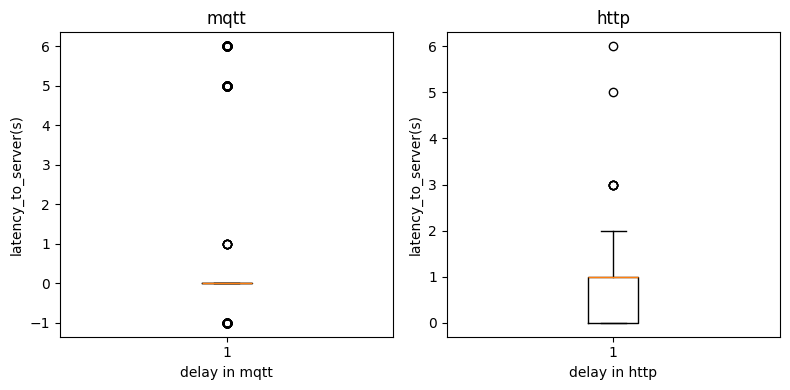

In [112]:
df_mqtt = df[df['protocol'] == 'mqtt']
df_http = df[df['protocol'] == 'http']

plot_two_boxplots(df1=df_mqtt, df2=df_http, column="latency_to_server(s)", title1="mqtt", title2="http", label1="delay in mqtt", label2="delay in http")

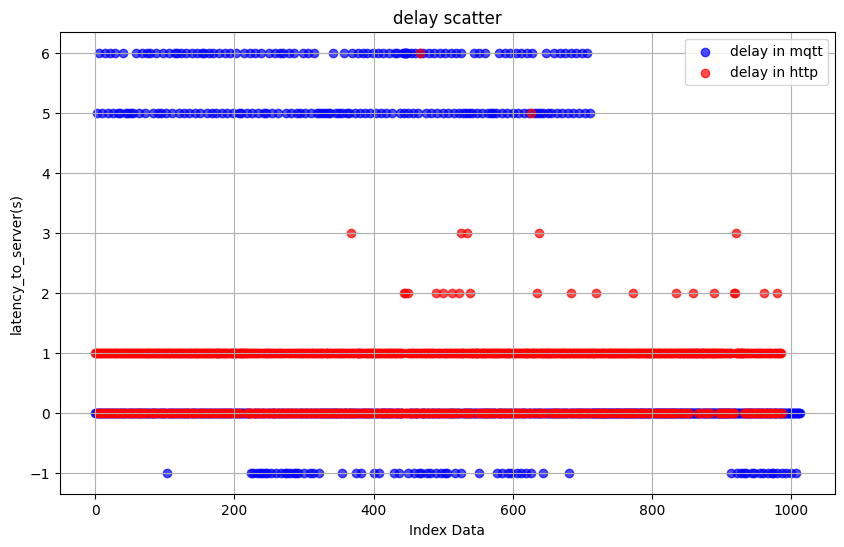

mean delay in mqtt:  0.9565646594274433
mean delay in http:  0.6737588652482269


In [ ]:
plot_two_scatter(df1=df_mqtt, df2=df_http, column="latency_to_server(s)", title="delay scatter", label1="delay in mqtt", label2="delay in http")
print("mean delay in mqtt: ", df_mqtt['latency_to_server(s)'].mean())
print("mean delay in http: ", df_http['latency_to_server(s)'].mean())